# Sliding Window Combined with CNN for paddy forest detection

# Preface

Original Article
**Using deep learning for paddy forest detection from Google Earth images.**

*Shuntaro Watanabe, Kazuaki Sumi, Takeshi Ise*

doi: https://doi.org/10.1101/351643

**Note**

Without using specialized  networks like U-net, but with a general CNN for classification, we still can perform a segmentation. The concept originates from the "Patch-based Classification", proposed in the following paper. See the slide below. Combining a sliding window patches with repatative CNN classification allows detection of the tumor region.

Watanabe et al., performed a similar approach to segment paddy forests from satelite images retreived from google earth.
They express their method as "chopped images", however paying respect to the previous research, I describe this method as "Patch-based Classification" as I interpret the principle is identical. 


*Deep Learning for Identifying Metastatic Breast Cancer*

*Dayong Wang Aditya Khosla⋆ Rishab Gargeya Humayun Irshad Andrew H Beck Beth Israel Deaconess Medical Center, Harvard Medical School**
https://arxiv.org/abs/1606.05718
![image](https://raw.githubusercontent.com/totti0223/deep_learning_for_biologists_with_keras/master/assets/cancer.png)




# Import Libraries

In [2]:
!pip install slidingwindow
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from sklearn.utils.class_weight import compute_class_weight


Using TensorFlow backend.


# Download dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
## Download and extract dataset
!unzip '/content/drive/My Drive/paddy.zip'

Archive:  /content/drive/My Drive/paddy.zip
   creating: paddy/
   creating: paddy/chopped/
   creating: paddy/test/
  inflating: paddy/test/test_image.png  
  inflating: paddy/test/test_image1.png  
  inflating: paddy/test/test_image11.png  
   creating: paddy/train/
  inflating: paddy/train/b1.png      
  inflating: paddy/train/b10.png     
  inflating: paddy/train/b11.png     
  inflating: paddy/train/b12.png     
  inflating: paddy/train/b13.png     
  inflating: paddy/train/b14.png     
  inflating: paddy/train/b15.png     
  inflating: paddy/train/b2.png      
  inflating: paddy/train/b4.png      
  inflating: paddy/train/b5.png      
  inflating: paddy/train/b6.png      
  inflating: paddy/train/b7.png      
  inflating: paddy/train/b8.png      
  inflating: paddy/train/b9.png      
  inflating: paddy/train/o1.png      
  inflating: paddy/train/o10.png     
  inflating: paddy/train/o11.png     
  inflating: paddy/train/o12.png     
  inflating: paddy/train/o13.png     
  inflati

## Preview

In [4]:
!ls paddy/train
#image names starting with "b" is image with only paddy forest.
#image names starting with "o" is image without paddy forest.

b10.png  b14.png  b4.png  b8.png   o12.png  o16.png  o2.png  o6.png
b11.png  b15.png  b5.png  b9.png   o13.png  o17.png  o3.png  o7.png
b12.png  b1.png   b6.png  o10.png  o14.png  o18.png  o4.png  o8.png
b13.png  b2.png   b7.png  o11.png  o15.png  o1.png   o5.png  o9.png


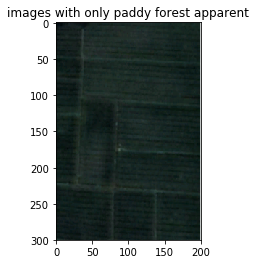

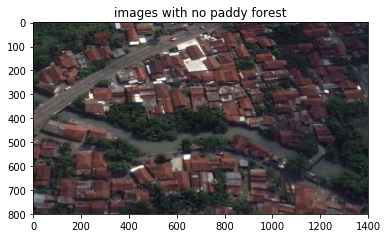

In [9]:
plt.title("images with only paddy forest apparent")
plt.imshow(imread("paddy/train/b1.png"))
plt.show()

plt.title("images with no paddy forest")
plt.imshow(imread("paddy/train/o16.png"))
plt.show()


# Create "patches" from each image using a sliding window

In [0]:
def save_to_folder(img_path,directory,size=56,overlap=0.4):
    #read imag from path save windows to the specified directory
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".png"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img)
        
files = os.listdir("paddy/train/")
files = [x for x in files if x.endswith(".png")]

for file in files:
    save_directory = "paddy/chopped"
    file = os.path.join("paddy/train/",file)
    save_to_folder(file,save_directory)

In [12]:
files = os.listdir("paddy/chopped/")
files = [x for x in files if x.endswith(".png")]

x = []
y = []

for file in files:
    if file.startswith("b"):
        label = 1
    else:
        label = 0
    
    img_path = os.path.join("paddy/chopped",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

x = np.array(x)
y = np.array(y)
print(x.shape,y.shape)

(0,) (0,)


In [13]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x,y,test_size=0.2,stratify = y)

print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

ValueError: ignored

In [0]:
#compute class weight
print(np.unique(train_y,return_counts=True))
print(np.unique(valid_y,return_counts=True))

cw = compute_class_weight("balanced",np.unique(train_y),train_y)
print(cw)

(array([0, 1]), array([ 700, 2093]))
(array([0, 1]), array([175, 524]))
[1.995      0.66722408]


# Build and Train CNN

In [0]:
model = Sequential([
    layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    layers.MaxPool2D((2,2),name="pool1"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool3"),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1),
    layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 56, 56, 16)        448       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 32)       

In [0]:
history = model.fit(train_x,train_y,epochs=10,validation_data=(valid_x,valid_y),class_weight=cw)

Train on 2793 samples, validate on 699 samples
Epoch 1/10
2793/2793 [==============================] - 7s 3ms/step - loss: 0.4177 - acc: 0.7931 - val_loss: 0.1515 - val_acc: 0.9757
Epoch 2/10
2793/2793 [==============================] - 1s 219us/step - loss: 0.1594 - acc: 0.9556 - val_loss: 0.1706 - val_acc: 0.9299
Epoch 3/10
2793/2793 [==============================] - 1s 223us/step - loss: 0.1278 - acc: 0.9671 - val_loss: 0.3759 - val_acc: 0.8512
Epoch 4/10
2793/2793 [==============================] - 1s 211us/step - loss: 0.1118 - acc: 0.9706 - val_loss: 0.0981 - val_acc: 0.9785
Epoch 5/10
2793/2793 [==============================] - 1s 212us/step - loss: 0.1036 - acc: 0.9689 - val_loss: 0.0731 - val_acc: 0.9900
Epoch 6/10
2793/2793 [==============================] - 1s 210us/step - loss: 0.0537 - acc: 0.9832 - val_loss: 0.0620 - val_acc: 0.9800
Epoch 7/10
2793/2793 [==============================] - 1s 208us/step - loss: 0.0422 - acc: 0.9860 - val_loss: 0.0309 - val_acc: 0.9914
Epo

# Evaluate against Test Data

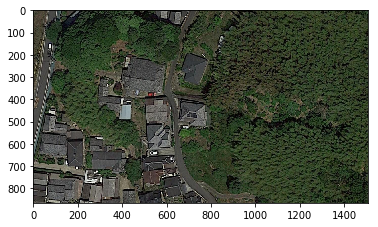

37
2405 37 65


In [0]:
#read test data
img_path = "paddy/test/test_image.png"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#create subimages
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#check total images, how many images are tiled at height direction, and width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)

(2405, 1)
[[0.3863537 ]
 [0.22590888]
 [0.26940566]
 ...
 [0.0035744 ]
 [0.02500287]
 [0.07929716]]


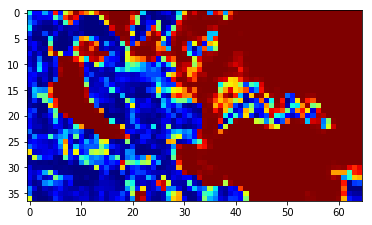

In [0]:
#predict the paddy probability for all the cropped images, and reshape back to its original form.
predictions = model.predict(patches)
print(predictions.shape)
print(predictions)

paddy = np.reshape(predictions,(n_total//n_x,n_x))
paddy = np.rot90(paddy)
paddy = np.flip(paddy,axis=0)
plt.imshow(paddy,cmap="jet")

note that each images correspond to 1 pixel of probability, and the size is not compatible with the input images.
we will caculate the ratio factor and resize it.

In [0]:
h_factor = img.shape[0]//paddy.shape[0]
w_factor = img.shape[1]//paddy.shape[1]
print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(paddy,(h_factor,w_factor))

print(zoomed.shape)

23
(851, 1495)


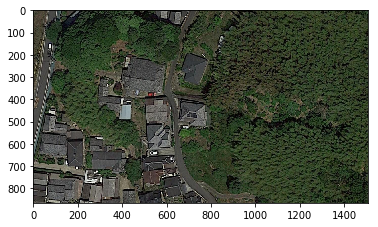

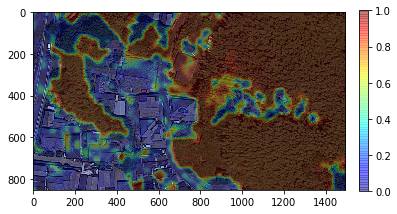

In [0]:
#result
plt.imshow(img)
plt.show()

plt.imshow(img)
plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()